# Expected Returns - Statistical Analysis

The goal is to find some insight into the following questions:
1. Frequency of stocks gaining 1-3% in a day
2. Frequency of stocks gaining 1-3% in a day after an after hours jump
3. Average overall volatility in a stock price. How often does the price vary 1%, 2%, 3% from high to low?
4. How often does a stock jump in the first 15-30 minutes and then end positive/negative?

In [1]:
# Import libraries and set up plotting
import sys
sys.path.append('scripts/')
import alpaca_trade_api as tradeapi
from helper_functions import *
from cam_paper_keys import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Create function to convert colors: rgb_colors
def rgb_color(r,g,b):
    r = r/255.
    g = g/255.
    b = b/255.
    return(r,g,b)

# Create colors:
tableau_blue = rgb_color(31,119,180)
dark_blue = '#092334'
orange = '#CB6B48'
grey = '#C7C7C7'

In [2]:
# Connect to API and load in SP500 tickers
api = connect_paper_api(paper_key_id, paper_secret_key)
symbols = save_sp500_tickers()

___
## 1. Intraday Gains/Loss Analysis

Our chasing jumps theory is currently based on the assumption that stocks will return **at least** a 1% return throughout the day (i.e from market open to market close). But is this true? Taking it a step further - what is distribution of intraday stock returns for positions in the S&P 500? Let's do some analysis.

Let's begin by pulling in the last 100 days open and close prices for each position in the S&P 500. We can then calculate the intraday return for each day (close-open/open) and then put this return into one of eight groups ('<-3%', '-3%-2%', '-2%-1%', '-1%-0', '0-1%', '1-2%', '2-3%', '> 3%'). With done for all the tickers in the S&P 500, we can find the overall distribution of intraday returns over the last 100 days in all possible stocks that our script would have picked.

In [3]:
returns_dict = dict()
counter = 0
for sym in symbols:
    try:
        hist_data = pull_hist_data(api, sym, '100 days', agg='day')[['open', 'close']]
        hist_data['days_return'] = (hist_data['close'] - hist_data['open'])/hist_data['open']
        hist_data['return_group'] = pd.cut(hist_data['days_return'], [-1, -0.03, -0.02, -0.01, 0,  0.01, 0.02, 0.03, 1], labels=['<-3%', '-3%-2%', '-2%-1%', '-1%-0', '0-1%', '1-2%', '2-3%', '> 3%'])
        returns_dict[sym] = hist_data.groupby('return_group')['close'].count().to_dict()
    except:
        counter += 1
        pass
df_returns = pd.DataFrame.from_dict(returns_dict, orient='index')
print ('Dataframe saved. Data pull issue with {} symbols'.format(counter))

Dataframe saved. Data pull issue with 0 symbols


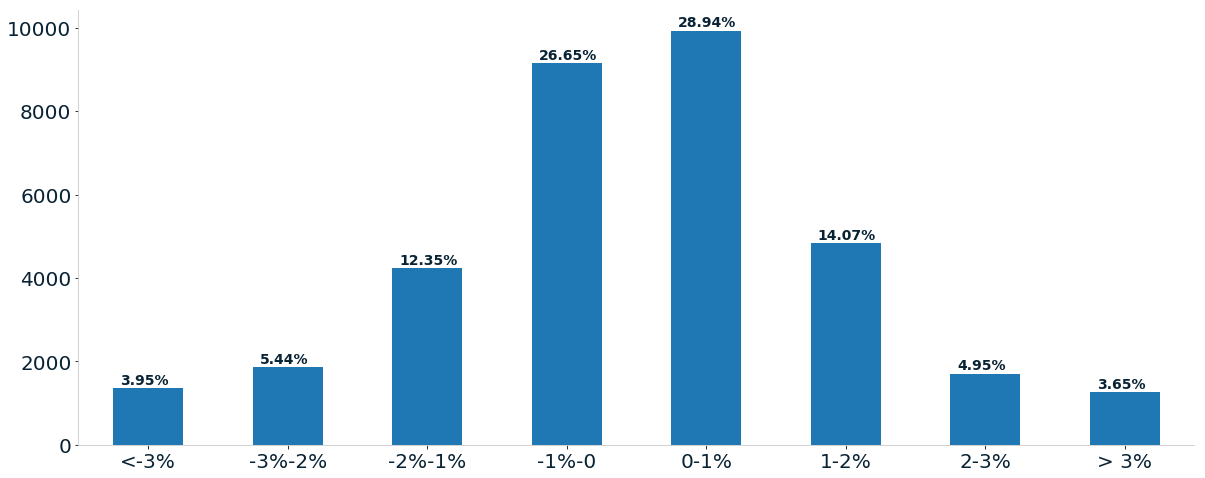

In [4]:
ax = df_returns.sum().plot(kind='bar', legend=False, figsize=(20,8), color=tableau_blue)
for i in range(8):
    pct = (df_returns.sum()/df_returns.sum().sum()).values[i]
    val = df_returns.sum().values[i]
    plt.annotate('{}%'.format(str(round(pct*100, 2))), (i-0.2, val+100), fontsize=14, weight='bold', color=dark_blue)
plt.ylabel('')
plt.yticks(color=dark_blue, fontsize=20)
plt.xticks(rotation=0, color=dark_blue, fontsize=20)
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color(grey) 
ax.spines['left'].set_color(grey)
plt.show()

We can see from the bar chart that the most often intraday return is a return of 0-1% which happens about 29% of the time. This is probably to be expected from our expereince over the last few weeks. The next most likely outcome is a loss of 0-1% at about 26% of the time and again this is not surprising. But what is interesting is this is based on the assumption that we are choosing our stocks **randomly**, or simply put, this is our baseline. If we randomly pick a stock at 9:30 and sell it at the close of the day, we, statiscially speaking, should make 0-1% 29% of the time, lose 0-1% 26% of the time, etc, etc, etc. 

The real question becomes how do we improve on this baseline? If we only chose stocks that we're "prioritized high" by our algorithm are we more likely to have a position with a strong positive return? Let's find out...